# **Capitulo 3 – Dimensionality Reduction**

# Setup

Como hicimos en Notebooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/dim_reduction` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Reducción de la dimensionalidad

Muchos problemas de Machine Learning implican miles o incluso millones de características para cada instancia de entrenamiento. Todas estas características no sólo hacen que el entrenamiento sea extremadamente lento, sino que también pueden hacer que sea mucho más difícil encontrar una buena solución. Este problema se conoce a menudo como la maldición de la dimensionalidad. Afortunadamente, en los problemas del mundo real, a menudo es posible reducir considerablemente el número de características, convirtiendo un problema intratable en uno manejable. Por ejemplo, consideremos las imágenes MNIST: los píxeles de los bordes de la imagen son casi siempre blancos, por lo que se podrían eliminar completamente del conjunto de entrenamiento sin perder mucha información. Como vimos en el Notebook anterior, confirmamos que estos píxeles carecen totalmente de importancia para la tarea de clasificación. Además, dos píxeles vecinos suelen estar muy correlacionados: si los fusiona en un único píxel (por ejemplo, tomando la media de las intensidades de los dos píxeles), no perderá mucha información.

La reducción de la dimensionalidad provoca cierta pérdida de información, al igual que la compresión de una imagen en JPEG puede degradar su calidad, por lo que, aunque acelerará el entrenamiento, puede hacer que su sistema funcione ligeramente peor. También hace que los procesos sean un poco más complejos y, por tanto, más difíciles de mantener. Por lo tanto, es recomendable que primero intentes entrenar su sistema con los datos originales antes de considerar el uso de la reducción de la dimensionalidad. En algunos casos, la reducción de la dimensionalidad de los datos de entrenamiento puede filtrar algo de ruido y detalles innecesarios y, por tanto, aumentar el rendimiento, pero en general no lo hará; sólo acelerará el entrenamiento.

Además de acelerar el entrenamiento, la reducción de la dimensionalidad también es muy útil para la visualización de datos. Reducir el número de dimensiones a dos (o tres) permite trazar una vista condensada de un conjunto de entrenamiento de alta dimensión en un gráfico y, a menudo, obtener algunas ideas importantes mediante la detección visual de patrones, como los clústeres. Además, la visualización de datos es esencial para comunicar sus conclusiones a personas que no son científicos de datos, en particular, a los responsables de la toma de decisiones que utilizarán sus resultados.

En este Notebook hablaremos primero de la maldición de la dimensionalidad y nos haremos una idea de lo que ocurre en el espacio de alta dimensión. A continuación, consideraremos los dos enfoques principales de la reducción de la dimensionalidad (proyección y aprendizaje múltiple), y repasaremos tres de las técnicas de reducción de la dimensionalidad más populares: PCA, proyección aleatoria e incrustación lineal local (LLE).


# La maldición de la dimensionalidad

We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our minds (see Figure 8-1), let alone a 200-dimensional ellipsoid bent in a 1,000-dimensional space

Estamos tan acostumbrados a vivir en tres dimensiones que nuestra intuición nos falla cuando intentamos imaginar un espacio de altas dimensiones. Incluso un hipercubo básico en 4D es increíblemente difícil de imaginar en nuestra mente, por no hablar de un elipsoide de 200 dimensiones doblado en un espacio de 1.000 dimensiones.

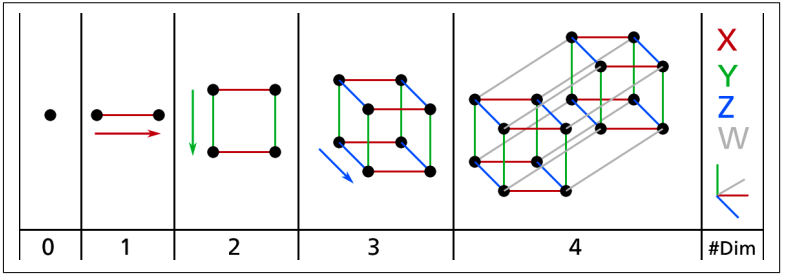

Resulta que muchas cosas se comportan de manera muy diferente en un espacio de alta dimensión. Por ejemplo, si elegimos un punto al azar en un cuadrado unitario (un cuadrado de 1 × 1), sólo tendrá una probabilidad aproximada del 0,4% de estar situado a menos de 0,001 de un borde (en otras palabras, es muy poco probable que un punto al azar sea "extremo" a lo largo de cualquier dimensión). Pero en un hipercubo unitario de 10.000 dimensiones, esta probabilidad es superior al 99,999999%. La mayoría de los puntos de un hipercubo de alta dimensión están muy cerca del borde.

He aquí una diferencia más problemática: si eliges dos puntos al azar en un cuadrado unitario, la distancia media entre esos dos puntos será de aproximadamente 0,52. Si eliges dos puntos al azar en un cubo unitario tridimensional, la distancia media será de aproximadamente 0,66. Pero, ¿qué ocurre con dos puntos elegidos al azar en un hipercubo unitario de 1.000.000 de dimensiones? La distancia media, aunque parezca mentira, será de 408,25 (aproximadamente $\sqrt{\frac{1. 000.000} {6}}$). Esto es contraintuitivo: ¿cómo pueden estar tan alejados dos puntos cuando ambos se encuentran dentro del mismo hipercubo unitario? Pues bien, en las dimensiones altas hay mucho espacio. En consecuencia, los conjuntos de datos de altas dimensiones corren el riesgo de ser muy dispersos: es probable que la mayoría de las instancias de entrenamiento estén muy alejadas entre sí. Esto también significa que una nueva instancia probablemente estará muy lejos de cualquier instancia de entrenamiento, lo que hace que las predicciones sean mucho menos fiables que en dimensiones más bajas, ya que se basarán en extrapolaciones mucho mayores. En resumen, cuantas más dimensiones tenga el conjunto de entrenamiento, mayor será el riesgo de sobreajuste.

En teoría, una solución a la maldición de la dimensionalidad podría ser aumentar el tamaño del conjunto de entrenamiento para alcanzar una densidad suficiente de instancias de entrenamiento. Por desgracia, en la práctica, el número de instancias de entrenamiento necesarias para alcanzar una densidad dada crece exponencialmente con el número de dimensiones. Con sólo 100 características (un número significativamente menor que en el problema MNIST), todas comprendidas entre 0 y 1, se necesitarían más instancias de entrenamiento que átomos en el universo observable para que las instancias de entrenamiento tuvieran una diferencia media de 0,1 entre sí, suponiendo que estuvieran distribuidas uniformemente en todas las dimensiones.

Este capítulo comienza con varias figuras para explicar los conceptos de PCA y Manifold Learning. A continuación se muestra el código para generar estas figuras.

Generemos un pequeño conjunto de datos 3D. Es una forma ovalada, rotada en el espacio 3D, con puntos distribuidos de forma desigual y con bastante ruido:

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # inicializar el conjunto de datos 3D
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # distribución desigual
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # añadir más ruido
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # cambiar un poco

# Principales métodos de reducción de la dimensionalidad

Antes de sumergirnos en algoritmos específicos de reducción de la dimensionalidad, echemos un vistazo a los dos enfoques principales para reducir la dimensionalidad: la proyección y el aprendizaje múltiple.

# Projection

En la mayoría de los problemas del mundo real, las instancias de entrenamiento no están repartidas uniformemente en todas las dimensiones. Muchas características son casi constantes, mientras que otras están muy correlacionadas. Como resultado, todas las instancias de entrenamiento se encuentran dentro (o cerca) de un subespacio de dimensiones mucho más bajas del espacio de altas dimensiones. Esto suena muy abstracto, así que veamos un ejemplo.

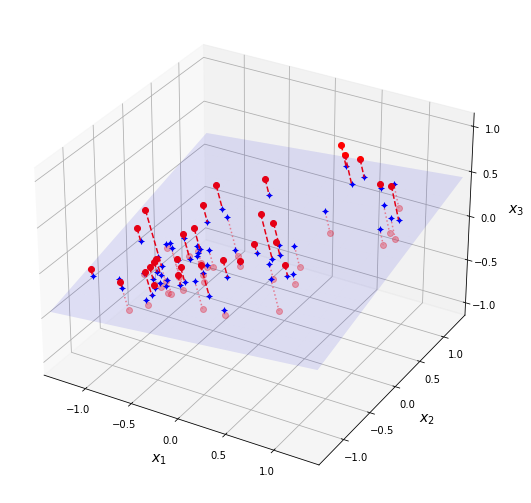

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # conjunto de datos reducido a 2D
X3D_inv = pca.inverse_transform(X2D)  # Posición 3D de las muestras proyectadas
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # coeficientes del plano de proyección
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plano
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # muestras sobre plano
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # muestras bajo plano

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# trazar primero las muestras y las líneas de proyección por debajo del plano
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # plano de proyección
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # muestras proyectadas
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# ahora trazar líneas de proyección y muestras sobre el plano
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

Observe que todas las instancias de entrenamiento se encuentran cerca de un plano: se trata de un subespacio de dimensión inferior (2D) del espacio de dimensión superior (3D). Si proyectamos cada instancia de entrenamiento perpendicularmente sobre este subespacio (representado por las líneas discontinuas cortas que conectan las instancias con el plano), obtenemos el nuevo conjunto de datos 2D que se muestra en la Figura. Y ¡tachán! Acabamos de reducir la dimensionalidad del conjunto de datos de 3D a 2D. Observe que los ejes corresponden a las nuevas características $z_1$ y $z_2$: son las coordenadas de las proyecciones sobre el plano.

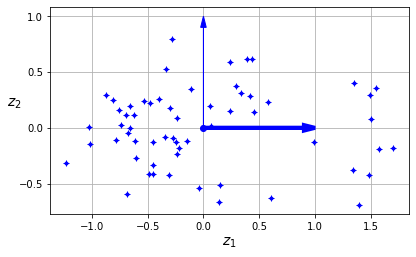

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

# Aprendizaje múltiple

Sin embargo, la proyección no siempre es el mejor enfoque para reducir la dimensionalidad. En muchos casos, el subespacio puede torcerse y girar, como en el famoso conjunto de datos de juguetes de rollo suizo representado en la Figura.

In [8]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

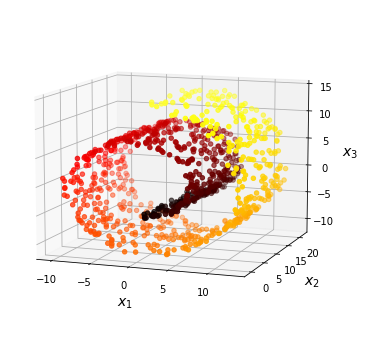

In [9]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

Simplemente proyectando sobre un plano (por ejemplo, soltando $x_3$) se aplastarían las diferentes capas del rollo suizo, como se muestra en la parte izquierda de la Figura. Lo que probablemente desee en su lugar es desenrollar el rollo suizo para obtener el conjunto de datos 2D de la parte derecha de la Figura.

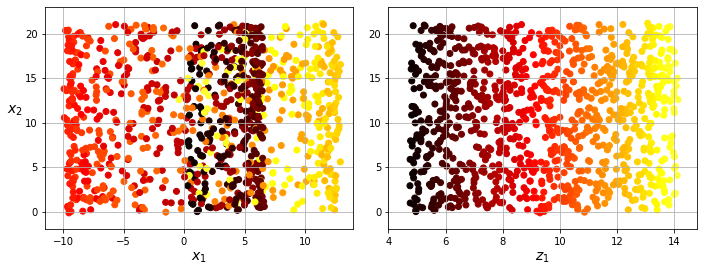

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

El rollo suizo es un ejemplo de colector 2D. En pocas palabras, un colector 2D es una forma 2D que puede doblarse y retorcerse en un espacio de dimensiones superiores. En términos más generales, un colector d-dimensional es una parte de un espacio n-dimensional (donde d < n) que localmente se asemeja a un hiperplano d-dimensional. En el caso del rollo suizo, d = 2 y n = 3: localmente se parece a un plano d-dimensional, pero se enrolla en la tercera dimensión.

Muchos algoritmos de reducción de la dimensionalidad se basan en el modelado de la matriz en la que se encuentran las instancias de entrenamiento, lo que se denomina aprendizaje de la matriz. Se basa en la suposición del maniflod, también llamada hipótesis del manyfold, que sostiene que la mayoría de los conjuntos de datos de alta dimensión del mundo real se encuentran cerca de un múltiple de dimensión mucho menor. Esta hipótesis se cumple empíricamente con mucha frecuencia.

Una vez más, pensemos en el conjunto de datos MNIST: todas las imágenes de dígitos manuscritos tienen algunas similitudes. Están formadas por líneas conectadas, los bordes son blancos y están más o menos centradas. Si se generaran imágenes al azar, sólo una fracción ridículamente pequeña de ellas se parecería a los dígitos manuscritos. En otras palabras, los grados de libertad de que dispone si intenta crear una imagen de dígitos son drásticamente inferiores a los grados de libertad que tiene si se le permite generar cualquier imagen que desee. Estas restricciones tienden a comprimir el conjunto de datos en una variedad de dimensiones inferiores.

El supuesto del manifold suele ir acompañado de otro supuesto implícito: que la tarea en cuestión (por ejemplo, clasificación o regresión) será más sencilla si se expresa en el espacio de dimensión inferior del múltiple. Por ejemplo, en la fila superior de la Figura, el rollo suizo se divide en dos clases: en el espacio tridimensional (a la izquierda), el límite de decisión sería bastante complejo, pero en el espacio 2D del manifold desenrollado (a la derecha), el límite de decisión es una línea recta.

Sin embargo, esta suposición implícita no siempre se cumple. Por ejemplo, en la fila inferior de la Figura, el límite de decisión está situado en $x_1 = 5$. Este límite de decisión parece muy simple en el espacio 3D original (un plano vertical), pero parece más complejo en el colector desenrollado (una colección de cuatro segmentos de línea independientes).

En resumen, reducir la dimensionalidad del conjunto de entrenamiento antes de entrenar un modelo suele acelerar el entrenamiento, pero no siempre conduce a una solución mejor o más sencilla; todo depende del conjunto de datos.

Espero que ahora tenga una buena idea de lo que es la maldición de la dimensionalidad y de cómo los algoritmos de reducción de la dimensionalidad pueden combatirla, especialmente cuando se cumple el supuesto del mainfold. El resto de este Notebook repasará algunos de los algoritmos más populares para la reducción de la dimensionalidad.

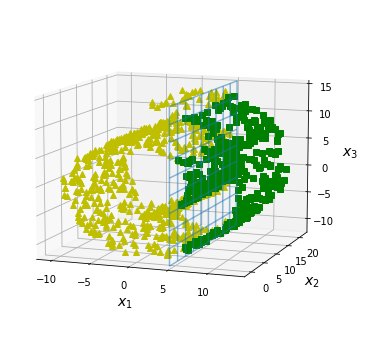

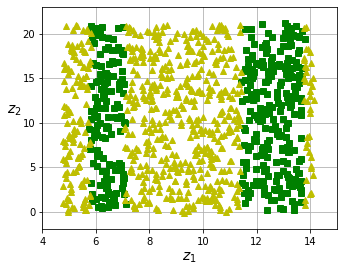

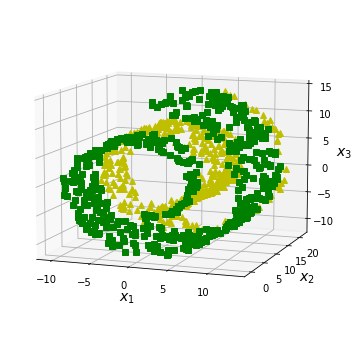

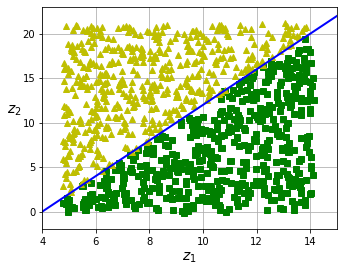

In [11]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()